# Analysis of exit wave reconstructed with MacTempas

MacTempas version 2.4.50


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.ticker import MultipleLocator
from scipy import ndimage
import os
import json

import tensorflow as tf
import tensorflow.keras as keras

from temnn.data.mods import local_normalize


/home/modules/software/Python/3.8.6-GCCcore-10.2.0/lib/python3.8/site-packages/cryptography/hazmat/bindings/openssl/binding.py:173: CryptographyDeprecationWarning: OpenSSL version 1.0.2 is no longer supported by the OpenSSL project, please upgrade. The next version of cryptography will drop support for it.
  warnings.warn(


### Select system

In [2]:
# system = 367
# system = 265
system = 862

### Read data

Read the raw data exported by MacTempas.

(409600,) 409600 640
Data range:
Real part: -0.21090007 0.1769998
Imaginary part: -0.22165905 0.3156957


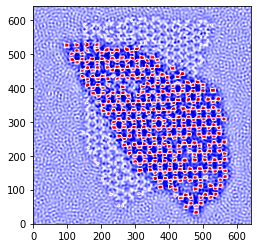

In [3]:
raw_exitwave_file = os.path.join(
    '../MacTempas_Exitwave_Reconstruction/20220516_convert',
    f'{system}',
    f'XW_{system}_sign'
)

reconstructed = np.fromfile(raw_exitwave_file, np.complex64)
size = int(np.sqrt(len(reconstructed)))
print(reconstructed.shape, 640*640, size)
reconstructed.shape = (size, size)
reconstructed = reconstructed.T - 1.0

plt.imshow(np.imag(reconstructed), cmap='seismic', origin='lower')
print("Data range:")
print("Real part:", np.real(reconstructed).min(), np.real(reconstructed).max())
print("Imaginary part:", np.imag(reconstructed).min(), np.imag(reconstructed).max())

Read the three images needed for the CNN exit wave reconstruction.

In [4]:
folder = '../workflow/simulation_data/MoS2_supported_reconstruct_15pm-test'
imfilename = os.path.join(
    folder,
    'images_labels',
    f'image_label_000_{system:04d}.npz'
)
paramfile = os.path.join(
    folder,
    'tem_params',
    f'parameters_000_{system:04d}'
)
data = np.load(imfilename)
images = data['image'][0]
images = images[:,:,(0,5,10)]  # Separate step as indexing a numpy file object is weird.
groundtruth = data['label'][0]
print('Image shape:', images.shape)
with open(paramfile) as f:
    params = json.load(f)
sampling = params['sampling']
defocus = params['defocus']

print("Sampling:", sampling, 'Å')
print("Defocus:", defocus)

Image shape: (640, 640, 3)
Sampling: 0.10844496012200482 Å
Defocus: [-103.3111727036499, -92.93431459003794, -82.6037054970652, -72.24797609196757, -62.352226951313376, -52.02324820673829, -41.571392873818, -31.931153948422647, -21.43929138611079, -11.787929376656571, -2.0817104878742807]


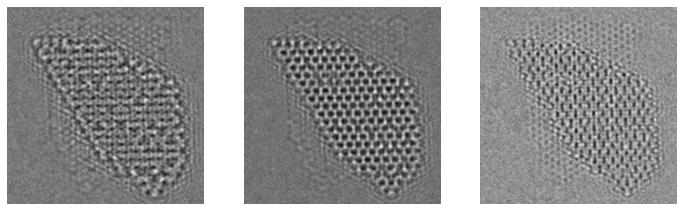

In [5]:
fig,axes=plt.subplots(1,3,figsize=(12,4))
for i in range(3):
    axes[i].imshow(images[:,:,i],cmap='gray', origin='lower')
    axes[i].axis('off')

### Exit wave reconstruction using the CNN

First load the model, then run it.

In [6]:
modeldir = '../workflow/trained_networks/MoS2_supported_15pm'
modelfile = os.path.join(modeldir, 'model-0')
print(f'Loading model from {modelfile} ...')
model = keras.models.load_model(modelfile)
print('... done.')

Loading model from ../workflow/trained_networks/MoS2_supported_15pm/model-0 ...
... done.


In [7]:
normrange = 12.0 / sampling
print(f"Sampling: {sampling:.5f} Å   Normalization range: {normrange:.2f} px")
img2 = local_normalize(images, normrange, normrange)
img2.shape = (1,) + img2.shape
print("Predicting")
reconstructed_cnn = model.predict(img2)[0]
print(reconstructed_cnn.shape)
print("Data range:")
print("Real part:", reconstructed_cnn[:,:,0].min(), reconstructed_cnn[:,:,0].max())
print("Imaginary part:", reconstructed_cnn[:,:,1].min(), reconstructed_cnn[:,:,1].max())

Sampling: 0.10844 Å   Normalization range: 110.66 px
Predicting
(640, 640, 2)
Data range:
Real part: -0.12974852 0.13313991
Imaginary part: -0.006475959 0.76825005


### Fourier filtering of ground truth

We need to remove the low frequencies before comparing to the MacTempas reconstruction, as they are not reconstructed.

In [8]:
wave = groundtruth[:,:,0] + 1j * groundtruth[:,:,1]
tmp1 = np.fft.fft2(wave)
tmp2 = ndimage.fourier_gaussian(tmp1, sigma=8)
groundtruth_hipass = wave - np.fft.ifft2(tmp2)

### Helper functions for plotting

In [9]:
def labelax(ax, lbl, **kwargs):
    ax.text(0.02, 0.98, lbl, fontsize=16, 
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes, **kwargs)
    
def myplot(ax, data, **kwargs):
    ax.imshow(data, origin='lower', **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [10]:
#maxval = max(wave.imag.max(), reconstructed.imag.max(), reconstructed_cnn.imag.max())
#minval = min(wave.imag.min(), reconstructed.imag.min(), reconstructed_cnn.imag.min())
maxval = groundtruth.max()
minval = groundtruth.min()
print("Values in [{}, {}]".format(minval, maxval))
maxval = max(-minval, maxval)
maxval = 1.08
minval = -maxval

Values in [-0.13455678522586823, 0.732712984085083]


### Plotting the figure (small version)

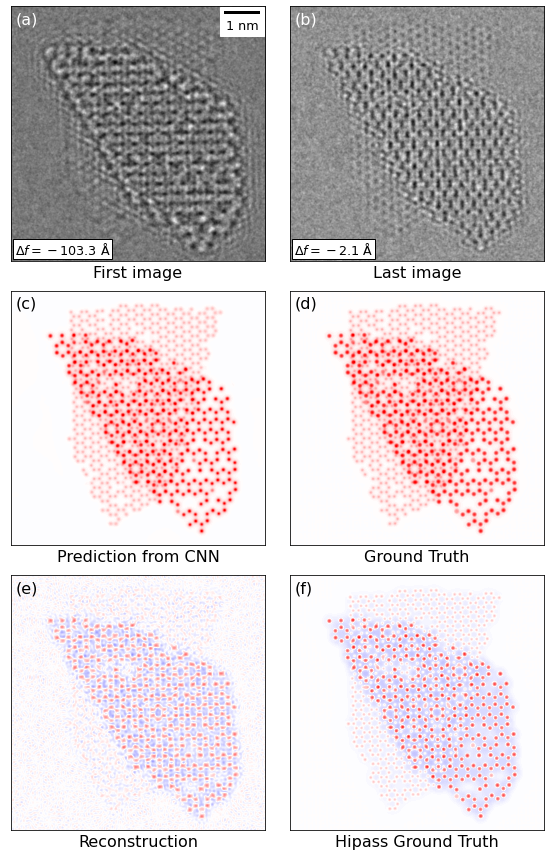

In [11]:
fig, ax = plt.subplots(3,2,figsize=(8,12))
labelsize = 16
cmap = 'seismic'

for i in range(2):
    imax = ax[0][i]
    imax.imshow(images[:,:,2*i], origin='lower', cmap='gray')
    imax.set_xticks([])
    imax.set_yticks([])
    imax.text(10, 10, 
              f'$\Delta f = {defocus[10*i]:.1f}$ Å',
              ha='left', va='bottom',
              bbox=dict(fc='white', ec=None, boxstyle='square,pad=0.15'),
              fontsize = 0.8 * labelsize)
ax[0][0].set_xlabel('First image', fontsize=labelsize)
ax[0][1].set_xlabel('Last image', fontsize=labelsize)
labelax(ax[0][0], '(a)', color='w')
labelax(ax[0][1], '(b)', color='w')

myplot(ax[1][0], reconstructed_cnn[:,:,1], cmap=cmap, vmax = maxval, vmin = minval)
ax[1][0].set_xlabel('Prediction from CNN', fontsize=labelsize)
labelax(ax[1][0], '(c)')

myplot(ax[1][1], groundtruth[:,:,1], cmap=cmap, vmax = maxval, vmin = minval)
ax[1][1].set_xlabel('Ground Truth', fontsize=labelsize)
labelax(ax[1][1], '(d)')

myplot(ax[2][0], reconstructed.imag, cmap=cmap, vmax = maxval, vmin = minval)
ax[2][0].set_xlabel('Reconstruction', fontsize=labelsize)
labelax(ax[2][0], '(e)')

myplot(ax[2][1], groundtruth_hipass.imag, cmap=cmap, vmax = maxval, vmin = minval)
ax[2][1].set_xlabel('Hipass Ground Truth', fontsize=labelsize)
labelax(ax[2][1], '(f)')

# Place a scalebar
scalebar = ScaleBar(0.1*sampling, 'nm', fixed_value=1, pad=0.4, 
                    font_properties={'size': 0.8 * labelsize})
ax[0][0].add_artist(scalebar)

plt.tight_layout()
plt.savefig(f'ReconstructionComparison_small_{system}.png', dpi=300)

In [12]:
reconstructed.imag.min(), reconstructed.imag.max()

(-0.22165905, 0.3156957)

In [13]:
groundtruth_hipass.imag.min(), groundtruth_hipass.imag.max()

(-0.12994820848490674, 0.5402062751581233)

### RMSE comparison

In [14]:
diff_cnn = reconstructed_cnn - groundtruth
rmse_cnn = np.sqrt( (diff_cnn**2).mean() )

diff_tempas = reconstructed - groundtruth_hipass
rmse_tempas = np.sqrt( (np.abs(diff_tempas)**2).mean() )

print("RMSE (CNN):", rmse_cnn)
print("RMSE (Tempas):", rmse_tempas)


RMSE (CNN): 0.013362362
RMSE (Tempas): 0.06107207161690672
